In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
#ignore warnigns
import warnings
warnings.filterwarnings("ignore")
#library to code explanation
import shap
#visualization
import matplotlib.pyplot as plt

tf.random.set_seed(42) # For reproducibility
# Generate some random numbers
a = tf.random.uniform([1], seed=42)
b = tf.random.uniform([1], seed=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
#metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import sys
sys.executable


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-10-29 11:30:33.336262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/opt/anaconda3/envs/tf/bin/python'

In [2]:
from tensorflow.keras.callbacks import LearningRateScheduler


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.visible_device_list = "0"
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.compat.v1.Session(config=config)

In [4]:
# Including MLflow
import mlflow
import mlflow.tensorflow
import os

In [5]:
#keras
from keras import backend as K

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16544638178397403927
xla_global_id: -1
]


In [8]:
#creating train_test data
target = pd.read_csv('/Users/gloriacarrascal/trabajo-grado/data/scaled_target_var.csv')
features = pd.read_csv('/Users/gloriacarrascal/trabajo-grado/data/scaled_features_var.csv', parse_dates=['Datetime'])

In [9]:
features.shape

(815, 9)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features[['altitud', 'longitud', 'dirviento', 'nubosidad', 'temperatura', 'vapor', 'rocio']], target, test_size=0.3)

In [11]:
def loos_visualization(history, num_model):
    # You can also visualize the training history to check for overfitting

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/Conv_model_{num_model}.png')
    plt.show()

In [12]:
tf_graph = tf.Graph()
tf_sess = tf.compat.v1.Session(graph=tf_graph)

In [13]:
mlflow.tensorflow.autolog(every_n_iter=2)

In [14]:
def learning_vs_loss(history, num_model, lr_schedule):
    learning_rates = [lr_schedule(epoch, 1e-3) for epoch in range(len(history.history['loss']))]
    losses = history.history['loss']


    plt.plot(learning_rates, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Loss')
    plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/learning_rate_vs_loss_{num_model}.png')
    plt.show()

In [15]:
from keras.layers import Dropout


In [16]:
from tensorflow.keras.callbacks import EarlyStopping


In [17]:
from keras.regularizers import l2


In [18]:
from keras.callbacks import LearningRateScheduler


In [19]:
from keras.layers import BatchNormalization


In [193]:
def ConvNN(activation, num_model, exp_name, learning_rate):

    model = Sequential()
    model.add(Conv1D(filters=80, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(filters=180, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=128, activation=activation, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(units=128, activation=activation, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Dense(units=128, activation=activation, kernel_regularizer=l2(0.1)))
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    mlflow.set_experiment(exp_name)

    with mlflow.start_run():

        early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

        #early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])



        #evaluate the model on the test set
        y_pred = model.predict(X_test)


        # evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        print(f"Mean Squared Error (MSE): {mse}")
        rmse = np.sqrt(mse)
        print(f"Root Squared Error (RMSE): {rmse}")
        mae = mean_absolute_error(y_test, y_pred)
        print(f"Mean Absolute Error (MAE): {mae}")
        r2 = r2_score(y_test, y_pred)
        print(f"R squared (R2): {r2}")
        mape = mean_absolute_percentage_error(y_test, y_pred)
        print(f"Mean Absolute Percentage Error (MAPE): {mape}")
        #visualization 
        loos_visualization(history, num_model)
        image_path = f'/Users/gloriacarrascal/trabajo-grado/graficas/Conv_model_{num_model}.png'
        mlflow.log_param("activation function", activation)
        mlflow.log_metric("Mean Squared Error_MSE", mse)
        mlflow.log_metric("Root Squared Error_RMSE", rmse)
        mlflow.log_metric("Mean Absolute Error_MAE", mae)
        mlflow.log_metric("R squared_R2", r2)
        mlflow.log_metric("Mean Absolute Percentage Error_MAPE", mape)
        mlflow.log_artifact(image_path)
        #mlflow.log_artifact(image_path2)
        os.remove(image_path)
        #os.remove(image_path2)
        #mlflow.tensorflow.log_model(model, "model")
        #mlflow.tensorflow.log_model(model, "model")
        mlflow.end_run()
    return y_pred


2023/10/30 22:28:27 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


Epoch 1/100
 1/15 [=>............................] - ETA: 18s - loss: 18.4711WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0026s vs `on_train_batch_end` time: 0.0064s). Check your callbacks.


15/15 [==============================] - 1s 14ms/step - loss: 17.0490 - val_loss: 15.7516
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 14.4915 - val_loss: 13.7802
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 12.5542 - val_loss: 12.0547
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 10.8076 - val_loss: 10.6195
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 9.3821 - val_loss: 9.3305
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 8.2283 - val_loss: 8.3119
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 7.1969 - val_loss: 7.3970
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 6.3542 - val_loss: 6.6054
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 5.6395 - val_loss: 6.1008
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 5.0371 - val_loss: 5.4888
Epoch 11/100

2023/10/30 22:28:34 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/10/30 22:28:34 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023-10-30 22:28:35.249331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder te

INFO:tensorflow:Assets written to: /var/folders/_8/stsrqpjs1q1559jp3dtpqv0c0000gn/T/tmp9sb5shn3/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/_8/stsrqpjs1q1559jp3dtpqv0c0000gn/T/tmp9sb5shn3/model/data/model/assets


8/8 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 0.03819199493149811
Root Squared Error (RMSE): 0.1954277230371835
Mean Absolute Error (MAE): 0.14910811354190764
R squared (R2): 0.9632741367486402
Mean Absolute Percentage Error (MAPE): 0.37626171142498904


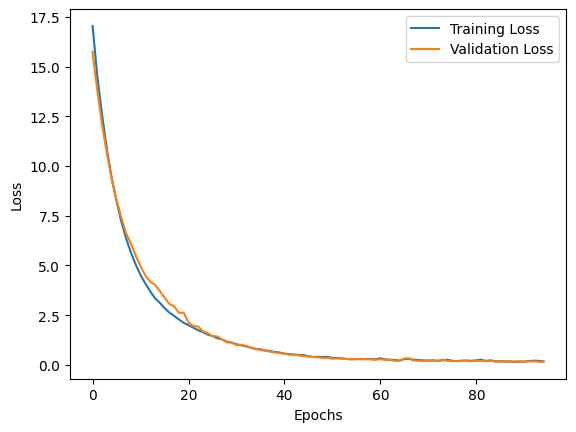

In [180]:
y_pred4= ConvNN(activation='relu', num_model=15, exp_name='CONV1:batchnormalization', learning_rate=0.001)


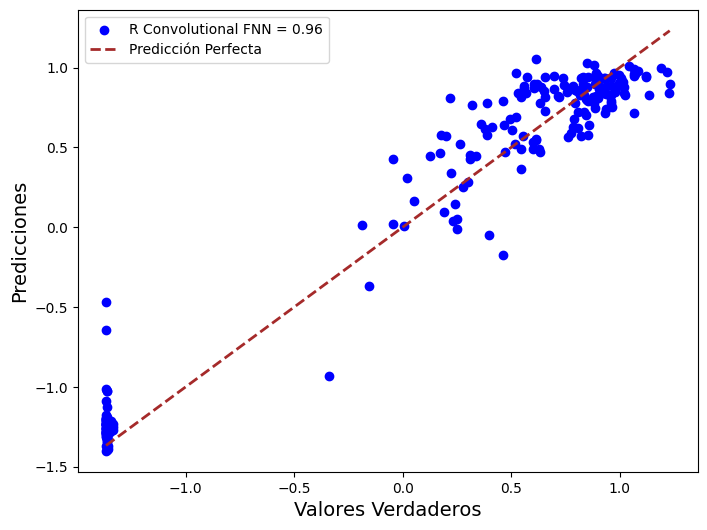

In [205]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import r2_score


# Calculate the R-squared score
r_squared = r2_score(y_test, y_pred4)

# Create a scatter plot of true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred4, c='blue', label=f'R Convolutional FNN = {r_squared:.2f}')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, c='brown', label='Predicción Perfecta')
plt.xlabel('Valores Verdaderos', fontsize=14)
plt.ylabel('Predicciones', fontsize=14)
#plt.title(f'R = {r_squared:.2f}')
plt.legend()
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/r_squared_CONVFNN.png')
plt.show()


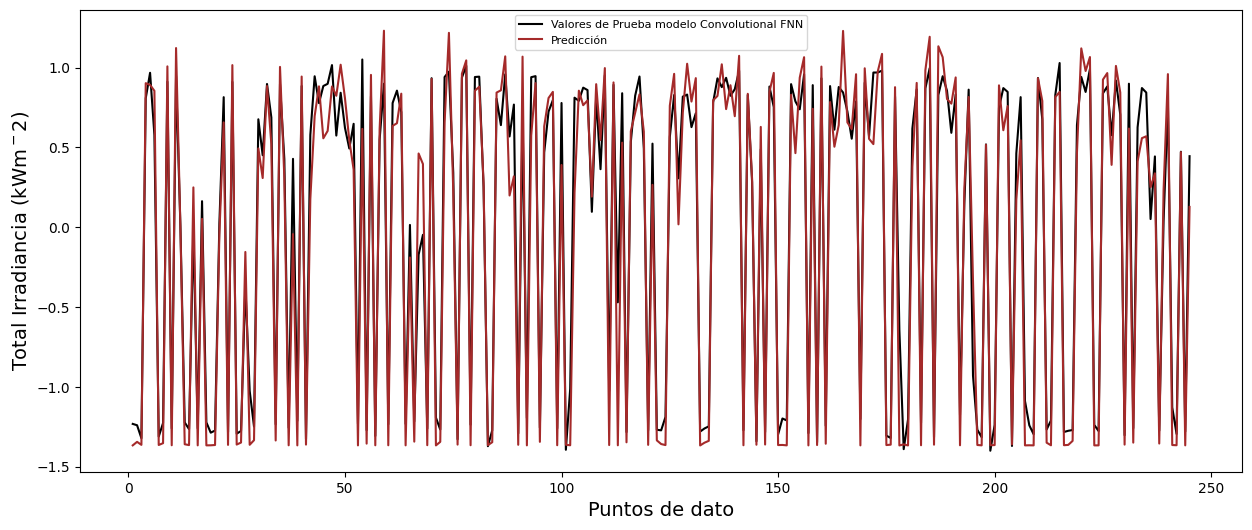

In [197]:
x_axis = np.arange(1, len(y_test) + 1)

# Create a line chart for y_true and y_pred
plt.figure(figsize=(15,6), dpi=100)
plt.plot(x_axis, y_pred4, label='Valores de Prueba modelo Convolutional FNN',linestyle='-', color='black')
plt.plot(x_axis, y_test, label='Predicción',linestyle='-', color='brown')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('Total Irradiancia (kWm$^-2$)', fontsize=14)
#plt.title('Valor vs. Predicted Values')
plt.legend(loc='upper center', fontsize=8)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/timeserie_CONVFNN.png')
plt.show()


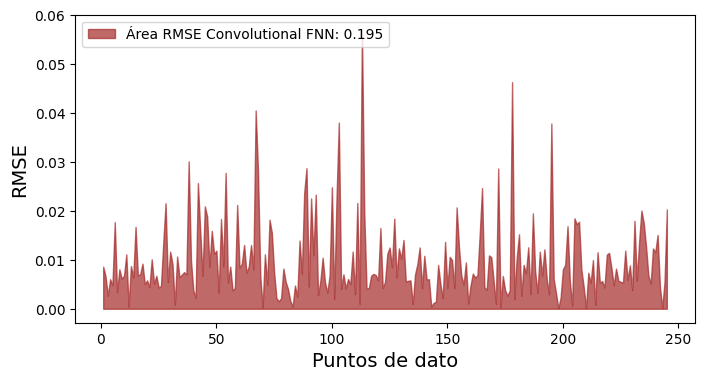

In [198]:
rmse = np.sqrt((y_test - y_pred4)**2 /len(y_test)) 


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
rmse = rmse.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, rmse, alpha=0.7, color='brown', label='Área RMSE Convolutional FNN: 0.195')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/RMSE_CONVFNN.png')
plt.show()


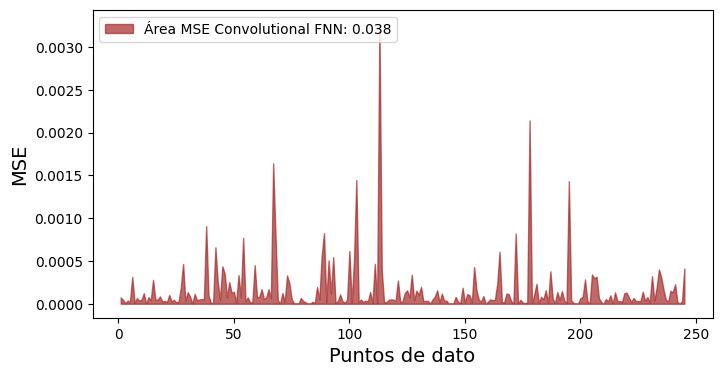

In [199]:
mse = (y_test - y_pred4)**2 /len(y_test)


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mse = mse.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mse, alpha=0.7, color='brown', label='Área MSE Convolutional FNN: 0.038')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MSE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/MSE_CONVFNN.png')
plt.show()

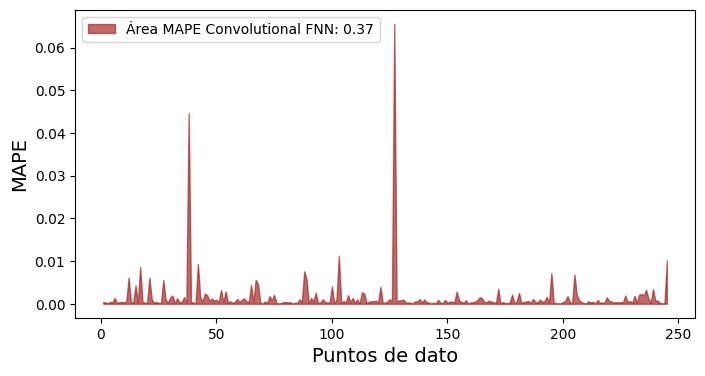

In [202]:
mape = np.abs((y_test - y_pred4)/y_test)/(len(y_test))


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mape = mape.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mape, alpha=0.7, color='brown', label='Área MAPE Convolutional FNN: 0.37')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MAPE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/MAPE_CONVFNN.png')
plt.show()

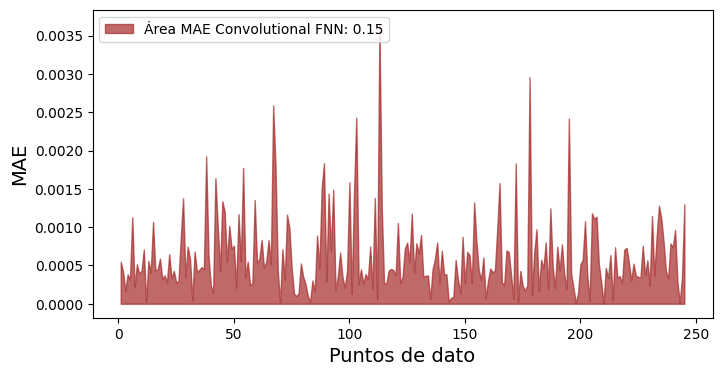

In [204]:
mae = np.abs(y_test - y_pred4)/len(y_test)


# Create an array for the x-axis (e.g., time or data points)
x_axis = np.arange(1, len(y_test) + 1)
# Reshape the multidimensional array to one dimension
mae = mae.to_numpy().flatten()

# Create a filled area plot of MAE over time
plt.figure(figsize=(8, 4))
plt.fill_between(x_axis, 0, mae, alpha=0.7, color='brown', label='Área MAE Convolutional FNN: 0.15')
plt.xlabel('Puntos de dato', fontsize=14)
plt.ylabel('MAE', fontsize=14)
#plt.title('Mean Absolute Error (MAE) Between y_test and y_pred')
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.savefig(f'/Users/gloriacarrascal/trabajo-grado/graficas/MAE_CONVFNN.png')
plt.show()